In [1]:
from dataset import AirQualityDataset
from dataset.raw_data import air_quality_test_data, air_quality_train_data
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

/home/hoang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
x = torch.rand(5, 4)

torch.stack((x, x, x), dim=1).shape

torch.Size([5, 3, 4])

In [2]:
from utils.functional import scale_softmax

In [3]:
x = torch.tensor([0.1, 0.01, 0.4, 0.05], dtype=torch.float)

torch.softmax(x, dim=0)

tensor([0.2372, 0.2168, 0.3202, 0.2257])

In [4]:
df = pd.read_csv("/home/hoang/Documents/CodeSpace/air-quality-forecasting/data/data-train/output/S0000367-To Hieu.csv")

# count contiguous missing data
count = 0
max_count = 0
start = None
for i in range(len(df)):
    if math.isnan(df["PM2.5"][i]):
        count += 1
    else:
        if max_count < count:
            max_count = count
        count = 0

max_count

128

In [5]:
eframe_size = 24 * 7
dframe_size = 24

def validate_frame(x: pd.Series):
    if x.isna().sum() == len(x):
        return 0
    return 1

l = 368
mask = []
for i in range(l):
    enc_start = i * dframe_size
    enc_end = enc_start + eframe_size
    dec_start = enc_end
    dec_end = dec_start + dframe_size

    mask.append([
        validate_frame(df["PM2.5"][enc_start : enc_end]),
        validate_frame(df["temperature"][enc_start : enc_end]),
        validate_frame(df["humidity"][enc_start : enc_end]),
    ])

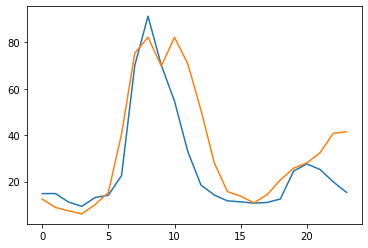

In [6]:
def get_slice(idx):
    start = idx * 24
    return slice(start, start + 24)

i = 7
plt.plot(df["PM2.5"][get_slice(i)].tolist())
plt.plot(df["PM2.5"][get_slice(i + 1)].tolist())

In [7]:
k = df["PM2.5"][7*24:8*24].copy()

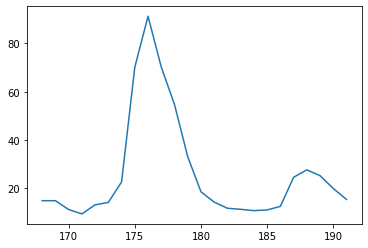

In [8]:
plt.plot(k)

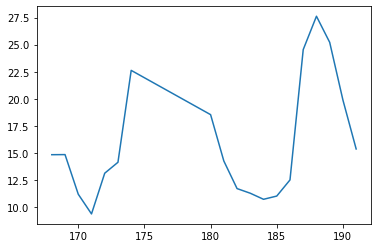

In [9]:
k[7:12] = float("nan")
plt.plot(k.interpolate(option="linear"))

In [10]:
from hydra import initialize, compose
import os
with initialize(version_base=None, config_path=os.path.relpath("/home/hoang/Documents/CodeSpace/air-quality-forecasting/config")):
  cfg = compose(config_name="cfg1.yaml")

In [2]:
dts = AirQualityDataset(
        "../data",
        normalize_mean={"humidity":0, "temperature": 0, "PM2.5": 0},
        normalize_std={"humidity": 1, "temperature": 1, "PM2.5": 1},
        # normalize_mean=cfg.data.normalize_mean,
        # normalize_std=cfg.data.normalize_std,
        droprate=0.5,
        data_set="train",
        fillnan_fn=lambda x: x.interpolate(option="spline").bfill()
    )

In [8]:
dt = dts[2]

In [10]:
dt["src_locs"]

tensor([[105.8505,  21.0269],
        [105.8056,  21.0391],
        [105.7834,  21.0383],
        [105.8507,  21.0287],
        [105.8126,  21.0261],
        [105.7338,  21.0069],
        [105.8013,  21.0501],
        [105.6796,  21.0446],
        [105.8489,  21.0116],
        [105.8590,  21.0251],
        [105.7851,  21.0261]])

In [9]:
dt["features"][4][:11].shape

torch.Size([11, 7])

In [9]:
dt["tar_loc"], dt["target_idx"]

(tensor([105.8241,  21.0317]), 2)

In [11]:
dt["gt_target"]

tensor([ 21.7400,  22.0600,  17.5300,  17.0200,  22.0600,  22.3300,  32.6200,
         68.2600, 108.1800,  86.6500,  69.7300,  43.5700,  25.9800,  19.4300,
         15.1700,  15.9000,  15.0100,  14.7300,  18.1400,  18.6600,  26.1100,
         30.2800,  20.8600,  18.1600])

In [16]:
from torch.utils.data import DataLoader
loader = DataLoader(dts, batch_size=32)

for batch in loader:
    print(batch["mask"])
    break

KeyError: 'mask'

In [ ]:
from model.layers import InverseDistanceAttention

/home/hoang/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [ ]:
dt = dts[4]

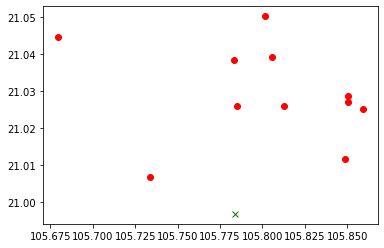

In [ ]:
plt.plot(dt["src_locs"][:, 0], dt["src_locs"][:, 1], "ro")
plt.plot(dt["tar_loc"][None, 0], dt["tar_loc"][None, 1], "gx")

In [ ]:
src_grids, tar_grid = InverseDistanceAttention({"attn_dropout": 0.1}, 4).locs_to_grid(dt["src_locs"].unsqueeze(0), dt["tar_loc"][None, None, :])

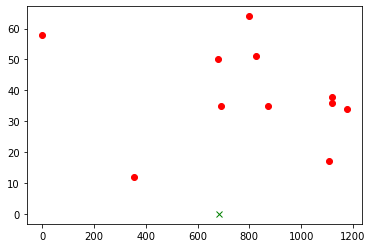

In [ ]:
plt.plot(src_grids[0, :, 0], src_grids[0, :, 1], "ro")
plt.plot(tar_grid[0, :, 0], tar_grid[0, :, 1], "gx")

In [ ]:
raw = air_quality_train_data("../data/data-train/")

In [ ]:
from statistics import mean
m, s = [], []

for name, station in raw["input"].items():
    m.append(station["data"]["humidity"].dropna().mean())
    s.append(station["data"]["humidity"].dropna().std())

{
    "mean": mean(m),
    "std": mean(s)
}

{'mean': 75.83080892930954, 'std': 14.527020139735658}

In [ ]:
import torch
x = torch.rand((2, 3))
mask = torch.tensor([[1, 0, 1], [0 ,1, 1]])

In [ ]:
x[:, [0, 2]]

tensor([[0.3108, 0.7506],
        [0.0180, 0.2285]])

In [ ]:
x

tensor([[0.3108, 0.6422, 0.7506],
        [0.0180, 0.2853, 0.2285]])